<a href="https://colab.research.google.com/github/LivenetsTatiana/works/blob/main/MachineLearning/LeastSquaresMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ### **<center>Применение метода наименьших квадратов<center/>**
**Цель**: изучить и реализовать метод наименьших квадратов

**Исходные данные:** сгенерированный набор данных

**Задания:**
1. Изучить статью "Метод наименьших квадратов: формулы, код и применение"
2. Повторить все этапы работы в собственном блокноте (включая формулы (текстовые ячейки) и графики)
3. Написать построенные комментарии в коде (используйте #)
4. По аналогии с примером из статьи придумать собственный набор данных
5. Реализовать весь процесс, описанный в статье с собственным набором данных (обратите внимание на распределение и блок статьи с дополнительными данными (выбросами))
6. Проверить результаты работы с помощью библиотеки sklearn (LinearRegression)
7. Написать выводы о проделанной работе



# **Необходимые библиотеки**

In [ ]:
import random # для генерации случайных чисел
import matplotlib.pyplot as plt # для визуализации
import numpy as np # для операций с матрицами
from sklearn.linear_model import LinearRegression # для проверки результатов

# **Генерация данных**


В качестве анализируемых данных будем рассматривать n значений популяции слонов, измеренной в особях, зависящие от времени. Эти данные представим в виде таблицы, где строки – это объекты, первый столбец – набор параметров (j=1), второй столбец – набор измеренных ответов:



$$
\begin{array}{|c|c|}
\hline \begin{array}{c}
\text { Порядковый }(i \text {-ый }) \\
\text { номер измерения } x_i
\end{array} & \text { Оценка численности популяции, }{ шт } \\
\hline x_1 & y_1 \\
\hline x_2 & y_2 \\
\hline \ldots & \ldots \\
\hline x_n & y_n \\
\hline
\end{array}
$$

Математически регистрируемый процесс можно описать в виде
$$
y_i=w_0+w_1 x_i+\varepsilon_i, i=1, \ldots, n,    \qquad \qquad   (1)
$$
где

$w_0$ - действительное значение свободного коэффициента модели,

$w_1$ - действительное значение весового коэффициента модели,

$\varepsilon_i-$ белый гауссовский (нормальный) шум, т.е. случайная величина, распределённая по закону Гаусса с фиксированным значением среднеквадратического отклонения (СКО), нулевым математическим ожиданием (МО) и с автокорреляционной функцией в виде дельта-функции.

Приведенный далее код реализует выражение (1) с заданными начальными значениями:
- действительных значений весовых коэффнциентов $w_0=2, w_1=3$;
- размера генерируемого набора данных $n=100$;
- порядковый номер измерений температуры ( $i$ меняется от 0 до 99 с шагом 1 ;
- значение СКО шума добавляемого к данным $\sigma(\varepsilon)=10$;
- МО шума добавляемого к данным $\mu(\varepsilon)=0$
- фиксируем начальное состояния генератора случайных чисел для повторяемости результатов (random_state $=50$ ).

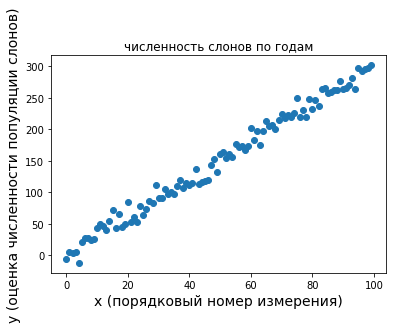

In [ ]:
def datasets_make_regression(coef, data_size, noise_sigma, random_state): # функция для генерации данных по формуле (1),
                                                                          # на вход коэффициенты формулы (1), количество генерируемых значений
                                                                          # и начальное состояние генератора случайных чисел, чтобы при повторной
                                                                          # компиляции с этим же состоянием значения не менялись
    x = np.arange(0, data_size, 1) # массив для данных
    mu = 0 # матожидание для шума
    random.seed(random_state) # в генератор случайных чисел заносим начальное состояние
    noise = np.empty((data_size, 1)) # пустой массив для шума размером с массив x и типом int
    y = np.empty((data_size, 1)) # пустой массив для численности слонов размером с массив x и типом int

    for i in range(data_size): # генерим массив численности для каждого года из 100 лет по формуле (1)
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = coef[0] + coef[1]*x[i] + noise[i]

    return x, y # возвращаем массив лет и массив численности животных

coef_true = [2, 3] # весовые коэффициенты
data_size = 100 # размер генерируемого набора данных
noise_sigma = 10 # СКО шума в данных
random_state = 50
x_scale, y_estimate = datasets_make_regression(coef_true, data_size, noise_sigma, random_state)

plt.plot(x_scale, y_estimate, 'o')  # строим график по сгенерированным данным
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка численности популяции слонов)', fontsize=14)
plt.title('численность слонов по годам')
print()

# **Математические модели**

Далее математическая модель будет описана три раза. Последовательно уровень абстракции при описании модели будет понижаться и конкретизироваться. Эти описания приведены для того, чтобы в дальнейшем материал, приведенный в статье, можно было соотнести с классическими изданиями.

**Первое описание математической модели. Самое общее.**

Поскольку мы рассматриваем процесс, который связывает набор наблюдаемых параметров и измеренных ответов с минимальной ошибкой этой связи, то математическую модель этого процесса в общем виде можно представить
$$
\left\{\begin{array}{c}
f\left(w^*{ }_{j=\overline{1, u}}, x_{i=\overline{1, n}, j=\overline{1, k}}\right)=\hat{y}_{i=\overline{1, n}}\left(w^*, x\right), \\
w^* _{j=\overline{1, m}}=\underset{w^*}{\operatorname{argmin}}\left[Q\left(\hat{y}_{i=\overline{1, n}}\left(w^*, x\right), y_{i=\overline{1, n}}\right)\right] ;
\end{array}\right.  \qquad \qquad (M1)
$$
где

$\quad x_{i=\overline{1, n}, j=\overline{1, k}}-$ набор из $n$ значений объекта, где в каждый $i$-ый момент измеряется $k$ его параметров (матрица размерностью $n \times k$ ),

$i=\overline{1, n}-$ обозначение набора из $n$ индексов вида $i=1,2,3, \ldots, n$,

$w^*{ }_{j=1, u}-$ вектор параметров модели размерностью $u$,

$\hat{y}_{i=\overline{1, n}}\left(w^*, x\right)-i$-ая оценка ответа,

$f-$ функция, которая $i$-ый набор значений из $k$ параметров объекта, преобразует с использованием вектора параметров $w$ в $i$-ое значение ответа $\hat{y}_i$,

$Q$ - неотрицательная функция ошибки, оценивающая расстояние между рассчитанным значениями $\hat{y}_{i=1, n}$ и измеренным $y_{i=\overline{1, n}}$ на основе выбранной метрики.

**Второе описание математической модели. Общее описание линейной модели.**

Поскольку по условию задачи мы рассматриваем линейную зависимость, на которую влияет шум, имеющий нормальное распределение с нулевым средним значением, то используем линейную относительно параметров модель, а метрикой выберем расчёт СКО ошибки
$$
\left\{\begin{array}{c}
w_0^*+\sum_{j=1}^m w_j^* x_{i j}=\hat{y}_l\left(w^*, x\right), \\
Q\left(w^*, x\right)=\frac{1}{n} \sum_{i=1}^n\left(\widehat{y}_l\left(w^*, x\right)-y_i\right)^2 \\
w*_{j=\overline{1, m}}=\underset{w^*}{\operatorname{argmin}}\left[Q\left(w^*, x\right)\right]
\end{array}\right. \qquad \qquad (M2)
$$
где $x_{i=\overline{1, n}, j=\overline{1, m}}-$ набор из $n$ значений объекта, где в каждый $i$-ый момент измеряется $m$ его параметров (матрица размерностью $n \times \mathrm{m}$ ),

$w_0^*$ - свободный коэффициент модели,

$w^*{ }_{j=\overline{1, m}}-$ вектор весовых коэффициентов модели размерностью $m$,

$\hat{y}_i\left(w^*, x\right)-i$-ая оценка ответа, полученная с использованием свободного коэффициента $w_0$ и вектора параметров модели размерностью $w^*$,

$y_i-i$-ый измеренный ответ,

$Q$ - неотрицательная функция ошибки, оценивающая расстояние между рассчитанным значениями $\hat{y}_{i=\overline{1, n}}$ и измеренным $y_{i=1, n}$ на основе выбранной метрики.

**Третье описание математической модели. Модель конкретизирована под условия примера.**

Поскольку по условию задачи мы рассматриваем линейную зависимость одного параметра (поскольку $j=1$, то далее эту зависимость при описании опустим), на оценку которого влияет шум, имеющий нормальное распределение, то используем линейную модель с двумя коэффициентами
$w^*=\left(\begin{array}{l}w_1^* \\ w_0^*\end{array}\right)$, а метрикой выберем расчёт среднеквадратической ошибки
$$
\left\{\begin{array}{c}
w_0^*+w_1^* x_i=\widehat{y}_l\left(w^*, x\right), \\
Q\left(w_0^*, w_1^*, x\right)=\frac{1}{n} \sum_{i=1}^n\left(\hat{y}_l\left(w^*, x\right)-y_i\right)^2 \\
{\left[w_0^*, w_1^*\right]=\underset{w_0^*, w_1^*}{\operatorname{argmin}}\left[Q\left(w_0^*, w_1^*, x\right)\right]}
\end{array}\right.  \qquad \qquad (M3)
$$
где $x_{i=\overline{1, n}}-$ набор из $n$ значений объекта, где в каждый $i$-ый момент измеряется один его параметр (вектор размерностью $n$ ),

$w_0^*-$ свободный коэффициент модели,

$w_1^*-$ весовой коэффициент модели,

$\hat{y}_i\left(w^*, x\right)-i$-ая оценка ответа, полученная с использованием свободного коэффициента $w_0^*$ и параметра модели $w_1^*$,

$y_i-i$-ый измеренный ответ,

$Q$ - неотрицательная функция ошибки, оценивающая расстояние между рассчитанным значениями $\hat{y}_{i=1 . n}$ и измеренным $y_{i=1 . n}$ на основе выбранной метрики.

Далее с использованием выражения (M3) и МНК, синтезируем алгоритмы, оценивающие параметры модели.

# **Алгоритмы и реализующие их программы**

В общем случае задача нахождения коэффициентов модели (M3) заключается в нахождении двух переменных $w_0^*$ и $w_1^*$ при которых функция ошибки $Q$ принимает минимальное значение. То есть при данных $w_0^*$ и $w_1^*$ сумма квадратов отклонений экспериментальных данных от модельных (расчетных) значений будет наименьшей, собственно, поэтому метод наименьших квадратов и носит своё имя.

Таким образом, нахождение коэффициентов $w_0^*$ и $w_1^*$ сводится к нахождению экстремума функции двух переменных
$$
Q\left(w_0^*, w_1^*, x\right)=\frac{1}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right)^2
$$
Для этого необходимо
- найти частные производные функции $Q\left(w_0^*, w_1^*, x\right)$ по искомым $w_0^*, w_1^*$;
- приравнять полученные выражения к нулю;
- решить полученную систему из двух уравнений с двумя неизвестными.
Решение полученной системы уравнений и будет являться искомыми параметрами модели.
Опишем аналитическое решение этой системы детально. Выполним расчет производной функции $Q\left(w_0^*, w_1^*, x\right)$ по параметру $w_0^*$.

## Первый алгоритм оценки параметров модели

Начнем с применения правила дифференцирования функции представленной в виде суммы
$$
\frac{\partial Q\left(w_0^*, w_1^*, x\right)}{\partial w_0^*}=\frac{\partial\left(\frac{1}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right)^2\right)}{\partial w_0^*}=\frac{1}{n} \sum_{i=1}^n \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)^2}{\partial w_0^*}=
$$
применим правило дифференцирования сложной функции
$$
=\frac{1}{n} \sum_{i=1}^n \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)^2}{\partial\left(w_0^*+w_1^* x_i-y_i\right)} \cdot \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)}{\partial w_0^*}=
$$
применим правило дифференцирования функции представленной в виде суммы
$$
\begin{gathered}
=\frac{1}{n} \sum_{i=1}^n 2 \cdot\left(w_0^*+w_1^* x_i-y_i\right) \cdot\left(\frac{\partial w_0^*}{\partial w_0^*}+\frac{\partial\left(w_1^* x_i\right)}{\partial w_0^*}-\frac{\partial y_i}{\partial w_0^*}\right)= \\
=\frac{2}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right) \cdot(1+0-0)=\frac{2}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right)
\end{gathered}
$$
Выполним расчет производной функции $Q\left(w_0^*, w_1^*, x\right)$ по параметру $w_1^*$ и применим правило дифференцирования функции представленной в виде суммы
$$
\frac{\partial Q\left(w_0^*, w_1^*, x\right)}{\partial w_1^*}=\frac{\partial\left(\frac{1}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right)^2\right)}{\partial w_1^*}=\frac{1}{n} \sum_{i=1}^n \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)^2}{\partial w_1^*}=
$$
применим правило нахождения производной сложной функции
$$
=\frac{1}{n} \sum_{i=1}^n \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)^2}{\partial\left(w_0^*+w_1^* x_i-y_i\right)} \cdot \frac{\partial\left(w_0^*+w_1^* x_i-y_i\right)}{\partial w_1^*}=
$$
применим правило дифференцирования функции представленной в виде суммы
$$
\begin{gathered}
=\frac{1}{n} \sum_{i=1}^n 2 \cdot\left(w_0^*+w_1^* x_i-y_i\right) \cdot\left(\frac{\partial w_0^*}{\partial w_1^*}+\frac{\partial\left(w_1^* x_i\right)}{\partial w_1^*}-\frac{\partial y_i}{\partial w_1^*}\right)= \\
=\frac{2}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right) \cdot\left(0+x_i-0\right)=\frac{2}{n} \sum_{i=1}^n\left(\left(w_0^*+w_1^* x_i-y_i\right) \cdot x_i\right) .
\end{gathered}
$$
Приравняем полученные производные к нулю и решим полученную систему уравнений
$$
\left\{\begin{array}{c}
\frac{2}{n} \sum_{i=1}^n\left(w_0^*+w_1^* x_i-y_i\right)=0, \\
\frac{2}{n} \sum_{i=1}^n\left(\left(w_0^*+w_1^* x_i-y_i\right) \cdot x_i\right)=0 .
\end{array}\right.
$$
Раскроем скобки
$$
\left\{\begin{array}{c}
\sum_{i=1}^n w_0^*+\sum_{i=1}^n w_1^* x_i-\sum_{i=1}^n y_i=0 \\
\sum_{i=1}^n w_0^* x_i+\sum_{i=1}^n w_1^* x_i^2-\sum_{i=1}^n y_i x_i=0 .
\end{array}\right.
$$
Вынесем постоянные множители за скобки
$$
\left\{\begin{array}{c}
n \cdot w_0^*+w_1^* \sum_{i=1}^n x_i-\sum_{i=1}^n y_i=0 \\
w_0^* \sum_{i=1}^n x_i+w_1^* \sum_{i=1}^n x_i^2-\sum_{i=1}^n y_i x_i=0 .
\end{array}\right.
$$
Вынесем слагаемые с множителем «у» в правую часть уравнений
$$
\left\{\begin{aligned}
n \cdot w_0^*+w_1^* \sum_{i=1}^n x_i & =\sum_{i=1}^n y_i, \\
w_0^* \sum_{i=1}^n x_i+w_1^* \sum_{i=1}^n x_i^2 & =\sum_{i=1}^n y_i x_i .
\end{aligned}\right.
$$
Поставим слагаемые с множителем «x» в левой части в порядке убывания степеней
$$
\left\{\begin{array}{c}
w_1^* \sum_{i=1}^n x_i^2+w_0^* \sum_{i=1}^n x_i=\sum_{i=1}^n y_i x_i, \\
w_1^* \sum_{i=1}^n x_i+n \cdot w_0^*=\sum_{i=1}^n y_i
\end{array}\right.
$$
Для решения полученной системы алгебраических уравнения представим её в матричной форме
$$
\left(\begin{array}{cc}
\sum_{i=1}^n x_i^2 & \sum_{i=1}^n x_i \\
\sum_{i=1}^n x_i & n
\end{array}\right)\left(\begin{array}{l}
w_1^* \\
w_0^*
\end{array}\right)=\left(\begin{array}{c}
\sum_{i=1}^n y_i x_i \\
\sum_{i=1}^n y_i
\end{array}\right) .
$$
Выразим вектор В $^{\star}$ с искомыми весами выполнив умножение обеих частей равенства на обратную матрицу у
$$
\left(\begin{array}{l}
w_1^* \\
w_0^*
\end{array}\right)=\left(\begin{array}{cc}
\sum_{i=1}^n x_i^2 & \sum_{i=1}^n x_i \\
\sum_{i=1}^n x_i & n
\end{array}\right)^{-1}\left(\begin{array}{c}
\sum_{i=1}^n y_i x_i \\
\sum_{i=1}^n y_i
\end{array}\right)  \qquad \qquad (A1)
$$
Полученное выражение (A1) является решением системы уравнений и его можно уже использовать в качестве первого алгоритма оценки параметров модели. Ниже приведен код реализующий этот алгоритм.

## Код (1)

In [ ]:
def coefficient_reg_inv(x, y):
    size = len(x)
    # формируем и заполняем матрицу размерностью 2x2
    A = np.empty((2, 2)) # создаем пустую матрицу, куда потом положим элементы обратной матрицы
    A[[0], [0]] = sum((x[i])**2 for i in range(0,size)) # находим сумму квадратов элементов массива х
    A[[0], [1]] = sum(x) # находим сумму элементов массива х
    A[[1], [0]] = sum(x)
    A[[1], [1]] = size # один из элментов матрица - количество элементов массива х
    # находим обратную матрицу
    A = np.linalg.inv(A)
    # формируем и заполняем матрицу размерностью 2x1
    C = np.empty((2, 1)) # сюда потом положим вектор на который будем умножать нашу обратную матрицу А
    C[0] = sum((x[i]*y[i]) for i in range(0,size)) # сумма произведений членов матрицы х и у с одинаковыми индексами
    C[1] = sum((y[i]) for i in range(0,size)) # сумма членов массива у

    # умножаем матрицу на вектор
    ww = np.dot(A, C)
    return ww[1], ww[0] # возвращаем найденные параметры модели

[w0_1, w1_1] = coefficient_reg_inv(x_scale, y_estimate) # запускаем функцию на сгенерированных ранее данных
print(w0_1, w1_1)

[0.81766082] [3.00986101]


## Второй алгоритм оценки параметров модели

Выражение (A1) можно упростить, выполнив аналитический расчет обратной матрицы.

Найти обратную матрицу можно с использованием, например, алгебраических дополнений. Для пояснения поиска обратной матрицы введем новую переменную A. Пусть
$$
A=\left(\begin{array}{cc}
\sum_{i=1}^n x_i^2 & \sum_{i=1}^n x_i \\
\sum_{i=1}^n x_i & n
\end{array}\right), \text { тогда } A^{-1}=\frac{1}{\Delta} \cdot(B)^T
$$
где $\Delta=A_{11} A_{22}-A_{12} A_{21}-$ определитель матрицы $A$,
$B=\left(\begin{array}{cc}A_{22} & -A_{21} \\ -A_{12} & A_{11}\end{array}\right)-$ матрица алгебраических дополнений, составленная из миноров $M=\left(\begin{array}{ll}A_{22} & A_{21} \\ A_{12} & A_{11}\end{array}\right)$ матрицы $A$,
$(*)^T$ - транспонирование матрицы, указанной в скобках.
Итоговое выражение для обратной матрицы представим в виде
$$
A^{-1}=\frac{1}{A_{11} A_{22}-A_{12} A_{21}}\left(\begin{array}{cc}
A_{22} & -A_{12} \\
-A_{21} & A_{11}
\end{array}\right) \text {. }
$$
В (A1) подставим выражение для обратной матрицы ии после упрощения получим
$$
\left(\begin{array}{l}
w_1^* \\
w_0^*
\end{array}\right)=\left(\begin{array}{c}
\frac{n \cdot \sum_{i=1}^n y_i x_i-\sum_{i=1}^n x_i \cdot \sum_{i=1}^n y_i}{n \cdot \sum_{i=1}^n x_i^2-\left(\sum_{i=1}^n x_i\right)^2} \\
\frac{-\sum_{i=1}^n x_i \cdot \sum_{i=1}^n y_i x_i+\sum_{i=1}^n x_i^2 \cdot \sum_{i=1}^n y_i}{n \cdot \sum_{i=1}^n x_i^2-\left(\sum_{i=1}^n x_i\right)^2}
\end{array}\right)  \qquad \qquad (A2)
$$

## Код (2)

In [ ]:
def coefficient_reg_inv_analit(x, y):
    size = len(x)
    # выполним расчет числителя первого элемента вектора
    numerator_w1 = size*sum(x[i]*y[i] for i in range(0,size)) - sum(x)*sum(y)
    # выполним расчет знаменателя (одинаковый для обоих элементов вектора)
    denominator = size*sum((x[i])**2 for i in range(0,size)) - (sum(x))**2
    # выполним расчет числителя второго элемента вектора
    numerator_w0 = -sum(x)*sum(x[i]*y[i] for i in range(0,size)) + sum((x[i])**2 for i in range(0,size))*sum(y)

    # расчет искомых коэффициентов
    w1 = numerator_w1/denominator
    w0 = numerator_w0/denominator
    return w0, w1 # возвращаем параметры модели

[w0_2, w1_2] = coefficient_reg_inv_analit(x_scale, y_estimate) # запускаем на наших данных
print(w0_2, w1_2)

[0.81766082] [3.00986101]


## Третий алгоритм оценки параметров модели

Выполним дальнейшее упрощение полученного выражения (А2), чтобы получить более компактную форму записи. Умножим числитель и знаменатель каждого элемента матрицы на $ \frac{1}{n^2} $ и введем новые переменные используя термины математической статистики

1) $\frac{1}{n} \cdot \sum_{i=1}^n x_i=\bar{x}-$ оценка МО велнчнны $x$;

2) $\frac{1}{n} \cdot \sum_{i=1}^n y_i=\bar{y}-$ оценка МО велнчнны $y$;

3) $\frac{1}{n} \cdot \sum_{i=1}^n y_i x_i=\overline{x y}-$ оценка МО пронзведения велшчнн $x$ п $y$;

4) $\frac{1}{n} \cdot \sum_{i=1}^n x_i^2=\overline{x^2}-$ оценка МО величнны $x^2$;

5) $\sqrt{\frac{1}{n} \cdot \sum_{i=1}^n x_i^2-\left(\frac{1}{n} \cdot \sum_{i=1}^n x_i\right)^2}=\sqrt{\overline{x^2}-\bar{x}^2}=\sigma_x$ - оценка СКО величнны $x$;

6) $\sqrt{\frac{1}{n} \cdot \sum_{i=1}^n y_i^2-\left(\frac{1}{n} \cdot \sum_{i=1}^n y_i\right)^2}=\sigma_y-$ оценка СКО велнчнны $y$;

С учётом введённых переменных искомый вектор $w^*$ примет вид
$$
\left(\begin{array}{l}
w_1^* \\
w_0^*
\end{array}\right)=\left(\begin{array}{c}
\frac{\overline{x y}-\bar{x} \cdot \bar{y}}{\sigma_x^2} \\
\frac{-\bar{x} \cdot \overline{x y}+\overline{x^2} \cdot \bar{y}}{\sigma_x^2}
\end{array}\right) .
$$
Упростим полученные выражения. Домножим весовой коэффищиент $w_1^*$ на $1=\frac{\sigma_y}{\sigma_y}$.
$$
w_1^*=\frac{\overline{x y}-\bar{x} \cdot \bar{y}}{\sigma_x^2}=\frac{\overline{x y}-\bar{x} \cdot \bar{y}}{\sigma_x^2} \cdot \frac{\sigma_y}{\sigma_y}=\left(\frac{\overline{x y}-\bar{x} \cdot \bar{y}}{\sigma_x \sigma_y}\right) \cdot \frac{\sigma_y}{\sigma_x}=r_{x y} \cdot \frac{\sigma_y}{\sigma_x}
$$
Прибавим к числителю $w_0^*$ свободного коэффициента $0=-\bar{x}^2+\bar{x}^2$
$$
\begin{aligned}
& w_0^*=\frac{-\bar{x} \cdot \overline{x y}+\overline{x^2} \cdot \bar{y}}{\sigma_x^2}=\frac{-\bar{x} \cdot \overline{x y}+\left(\overline{x^2}-\bar{x}^2+\bar{x}^2\right) \cdot \bar{y}}{\sigma_x^2}=\frac{-\bar{x} \cdot \overline{x y}+\left(\sigma_x^2+\bar{x}^2\right) \cdot \bar{y}}{\sigma_x^2}= \\
& =\frac{-\bar{x} \cdot \overline{x y}+\sigma_x^2 \cdot \bar{y}+\bar{x}^2 \cdot \bar{y}}{\sigma_x^2}=\frac{\sigma_x^2 \cdot \bar{y}-\left(\bar{x} \cdot \overline{x y}-\bar{x}^2 \cdot \bar{y}\right)}{\sigma_x^2}=\bar{y}-\frac{\bar{x} \cdot \overline{x y}-\bar{x}^2 \cdot \bar{y}}{\sigma_x^2}= \\
& =\bar{y}-\frac{\bar{x} \cdot(\overline{x y}-\bar{x} \cdot \bar{y})}{\sigma_x^2} \cdot \frac{\sigma_y}{\sigma_y}=\bar{y}-\frac{\bar{x} \cdot(\overline{x y}-\bar{x} \cdot \bar{y})}{\sigma_x \sigma_y} \cdot \frac{\sigma_y}{\sigma_x}=\bar{y}-\bar{x} \cdot r_{x y} \cdot \frac{\sigma_y}{\sigma_x}=\bar{y}-\bar{x} \cdot w_1^*
\end{aligned}
$$
Таким образом итоговое выражение представим в виде:
$$
\left\{\begin{array}{c}
w_1^*=r_{x y}  \cdot \frac{\sigma_y}{\sigma_x} \\
w_0^*=\bar{y}-\bar{x} \cdot w_1^*
\end{array}\right.  \qquad \qquad (A3)
$$

## Код (3)

In [ ]:
def coefficient_reg_stat(x, y):
    size = len(x)
    avg_x = sum(x)/len(x) # оценка МО величины x
    avg_y = sum(y)/len(y) # оценка МО величины y
    # оценка МО величины x*y
    avg_xy = sum(x[i]*y[i] for i in range(0,size))/size
    # оценка СКО величины x
    std_x = (sum((x[i] - avg_x)**2 for i in range(0,size))/size)**0.5
    # оценка СКО величины y
    std_y = (sum((y[i] - avg_y)**2 for i in range(0,size))/size)**0.5
    # оценка коэффициента корреляции величин x и y
    corr_xy = (avg_xy - avg_x*avg_y)/(std_x*std_y)

    # расчет искомых коэффициентов
    w1 = corr_xy*std_y/std_x
    w0 = avg_y - avg_x*w1
    return w0, w1

[w0_3, w1_3] = coefficient_reg_stat(x_scale, y_estimate)
print(w0_3, w1_3)

[0.81766082] [3.00986101]


#  **Проверка с помощью библиотеки** *sklearn*

In [ ]:
# преобразование размерности массива x_scale для корректной работы model.fit
x_scale = x_scale.reshape((-1,1))
model = LinearRegression() # для создания линейной модели
model.fit(x_scale, y_estimate) # создаем модель по нашим данным
print(model.intercept_, model.coef_) # выводим коэффициенты модели

[0.81766082] [[3.00986101]]


# **Визуализация данных и расчетных значений**

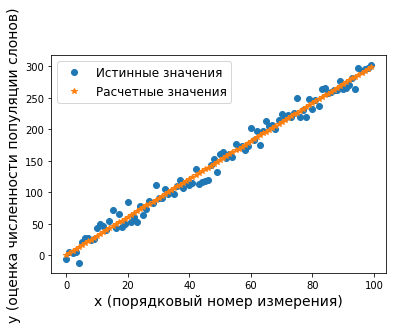

In [ ]:
def predict(w0, w1, x_scale): # функция рассчета значений численности слонов по найденным коэффициентам
    y_pred = [w0 + val*w1 for val in x_scale]
    return y_pred

y_predict = predict(w0_1, w1_1, x_scale)

# Визуализируем данные и рассчитанные значения
plt.plot(x_scale, y_estimate, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_predict, '*', label = 'Расчетные значения')
plt.legend(fontsize=12)
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка численности популяции слонов)', fontsize=14)
print()

# **Выбросы**

Создадим выбросы - значения численности популяции слонов, которые сильно выбиваются среди остальных данных.

К примеру возьмем 5 выбросов, которые будут находится через каддые 20 измерений и превосходить данные которые уже есть на этих местах на 200 особей

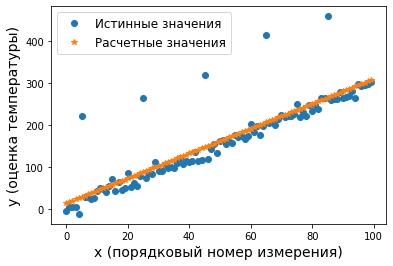

In [ ]:
ni = 5 # количество выбросов
ind_impuls = np.arange(ni, data_size, 20) # индексы выбросов
y_estimate_imp = y_estimate.copy() # выборка с выбросами
for i in range(0, ni):
    y_estimate_imp[ind_impuls[i]] += 200 # прибавляем к части значений 200 особей - это и будут выбросы

[w0_imp, w1_imp] = coefficient_reg_stat(x_scale, y_estimate_imp) # ищем коэффициенты прямой для данных с выбросами
y_pred_imp = predict(w0_imp, w1_imp, x_scale) # рассчитываем по уравнению прямой численность слонов
# визуализируем
plt.plot(x_scale, y_estimate_imp, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_pred_imp, '*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (оценка температуры)', fontsize=14)
print()

На рисунке видно, что появление выбросов сместило, рассчитанную по выражению (А3) прямую в вверх. Модифицируем алгоритм оценки параметров модели за счет новой метрики, а именно оценки квадратов разности между измеренными и модельными данными, которая выполняется по выражению
$$ SE_{i} = \left(w_0^*+w_1^* x_i-y_i\right)^2, i = \overline{1,n} \qquad \qquad (2)$$

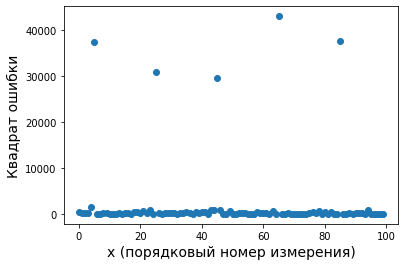

In [ ]:
# Вычисляем квадраты разности между измеренными и модельными данными по формуле (2)
SqErr = (y_pred_imp - y_estimate_imp)**2
# Визуализируем рассчитанные значения
plt.plot(x_scale, SqErr, 'o')
plt.xlabel('x (порядковый номер измерения)', fontsize=14)
plt.ylabel('Квадрат ошибки', fontsize=14)
print()

Для устранения влияния помехи на оценки параметров модели, получаемых с использованием алгоритмов, дополнительно введем процедуру цензурирования (отбрасывания) данных, которые имеют большое значение квадрата ошибки (2). С новыми начальными условиями алгоритм оценки параметров модели теперь дополняется следующей последовательностью действий:

1) отсортируем по возрастанию значения, полученные по выражению (2);

2) удалим значение из анализируемого набора данных, имеющее максимальное
отклонение от расчетного;

3) выполним оценку параметров модели $w_0^*$ и $w_1^*$, используя оставшиеся значения из
набора данных;

4) этапы 2 и 3 выполняем для 10% исходного набора данных (с запасом).



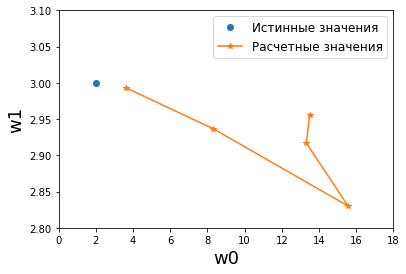

In [ ]:
def censor_data(SqErr, nCensor):
    # индексы отсортированного во возрастанию массива с квадратами ошибок
    I = np.argsort(SqErr[:,0])
    ind_imp = I[-nCensor:]
    ind_imp = ind_imp[::-1] # разворот индексов массива
    w0 = np.empty((nCensor, 1)) # пустой массив для w0 размером с массив nCensor (количество удаляемых выбросов) и типом int
    w1 = np.empty((nCensor, 1)) # пустой массив для w1 размером с массив nCensor и типом int

    for i in range(0,nCensor):
        # цензурирование данных (удаляем выбросы по одному, пока не удалим nCensor выбросов)
        x_scale_cens = np.delete(x_scale, ind_imp[0:i], 0)
        y_estimate_imp_cens = np.delete(y_estimate_imp, ind_imp[0:i], 0)
        # расчёт параметров прямой, после удаления каждого из выбросов
        w0[i], w1[i] = coefficient_reg_stat(x_scale_cens, y_estimate_imp_cens)
        y_pred2_cens = predict(w0[i], w1[i], x_scale_cens)
    return w0, w1

nCensor = 5 # количество отбрасываемых выбросов
[w0_с, w1_с] = censor_data(SqErr, nCensor) # получаем коэффициенты прямой, удаляя по одному выбросу
# Отображаем коэффициенты прямой без 1, 2 .. nCensor выбросов
plt.plot(coef_true[0], coef_true[1], 'o', label = 'Истинные значения')
plt.plot(w0_с, w1_с, '-*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlim((0.0, 18.0))
plt.ylim((2.8, 3.1))
plt.xlabel('w0', fontsize=18)
plt.ylabel('w1', fontsize=18)
print()

В результате работы рассматриваемого алгоритма видно, что по мере цензурирования помеховых данных параметры модели приближаются к истинным.

Ниже приведен код, который рассчитывает и строит на графике прямую с использованием параметров модели, полученной на последнем шаге алгоритма c цензурированием. На этом рисунке видно, что использование дополнительной процедуры цензурирования данных на основе анализа остаточной суммы квадратов, позволяет улучшить согласование оцениваемых параметров с истинными.

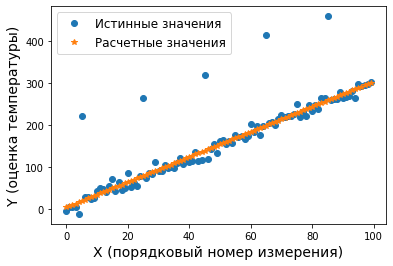

In [ ]:
y_pred_censor = predict(w0_с[nCensor-1], w1_с[nCensor-1], x_scale) # получаем параметры прямой без учета выбросов
# Отображаем данные и прямую с рассчитанными параметрами
plt.plot(x_scale, y_estimate_imp, 'o', label = 'Истинные значения')
plt.plot(x_scale, y_pred_censor, '*', label = 'Расчетные значения')
plt.legend(loc = 'best', fontsize=12)
plt.xlabel('X (порядковый номер измерения)', fontsize=14)
plt.ylabel('Y (оценка температуры)', fontsize=14)
print()

# **Выводы**
Рассмотрено применение метода наименьших квадратом на сгенерированных данных (численность слонов по годам).

Описаны математические модели (от наиболее общей до наиболее частной) и алгоритмы оценки параметров модели.

Произведена проверка результатов работы этих алгоритмов с помощью библиотеки *sklearn*.

Был рассмотрен алгоритм оценки параметров модели, которая описывает процесс изменения численности слонов по годам при наличии помех (например, резкий скачок рождаемости, и затем резкое вымирание из-за неумения найти альтернативную пищу в связи с таким скачком). Показано, как зная логику построения алгоритма его можно модифицировать под изменившиеся условия и получить необходимый результат (оценку параметров модели).



